# Implementing an Application

Applications are broadly defined as classes that represent a task, such as classification or regression, without depending heavily on the exact architecture. They are the highest level of abstraction in the Deeplay library. Applications are designed to be easy to use and require minimal configuration to get started. They are also designed to be easily extensible, so that you can add new features without having to modify the existing code.

## What Should Be Implemented as an Application?

The first step is to ensure that what you want to implement is actually an application.

Applications should generally not define the model, but rather receive it as an argument. 
(In some cases, it may be useful to have a default model, but this should be the exception.)
Therefore, applications should strive to be as model agnostic as possible, so that they can be used with any model that fits the input and output shapes.

Applications define the training and inference loops, and the loss function.
Applications may also define custom metrics, or specialmethods used for inference. Forexample, a classifier application may define a method to predict a hard label from the input, instead of the probabilities.

Examples of applications are `Classifier`, `Regressor`, `Segmentor`, and `VanillaGAN`.

## What Model(s) Should Be in an Application?

Most applications are composed of a single model, which is provided in the input arguments. Therefore, as a general rule of thumb, try to minimize the number of models in an application. Best is if there is a single model, accessed as `app.model`. 

Some applications require more,
such as `gan.generator` and `gan.discriminator`. This is fine, but try to keep it to a minimum. 

A bad example would be for a classifier to include `app.conv_backbone`, `app.conv_to_fc_connector` and `app.fc_head`. This is bad because it limits the flexibility of the application to architectures that fit this exact structure. Instead, the application should have a single model that can be easily replaced with a different one.

## Implementing an Application

Here you'll see the steps you should follow to implement an application in Deeplay. You'll do this through the concrete example of a binary classifier.

### 1. Create a New File

The first step is to create a new file in the `deeplay/applications` directory. It should generally be in a subdirectory, named after the type of application. For example, a binary classifier application should be in  `deeplay/applications/classificaiton/binary.py`.

**The base class: `Application`.** 
Applications should inherit from the `Application` class. This class is a subclass of both `DeeplayModule` and `lightning.LightningModule`. This is to ensure that the 
application is trainable with PyTorch Lightning.

This is an example for a binary classifier:


In [1]:
from deeplay.applications import Application
from deeplay.external import  Adam

import torch
import torch.nn as nn   
import torchmetrics as tm

class BinaryClassifier(Application):
    def __init__(self, model, **kwargs):
        # If no metrics are provided, add binary accuracy.
        # Note: Users can still set metrics=[] to disable all metrics.
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]

        # Note: It's good practice to allow loss and optimizer to be passed in
        # as arguments, so that users can customize them if they want to.
        # Here, this is skipped for simplicity.
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3),
                         **kwargs)

        self.model = model

    def forward(self, x):
        # Here the forward pass is defined.
        return self.model(x)

### 2. Implement the `.compute_loss()`method

The first method to implement is `.compute_loss()`. This method should receive
the predictions and the targets, and return the loss. In most cases, the default
behavior is sufficient, but you may want to implement a custom evaluation.

In this case, you'll convert the targets to float, since the loss function expects floats.

In [2]:
class BinaryClassifier(Application):
    def __init__(self, model, **kwargs):
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]

        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3),
                         **kwargs)

        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def compute_loss(self, y_hat, y):
        # This method computes the loss.
        # The targets are casted to float to match the expected type of the 
        # loss function.
        return super().compute_loss(y_hat, y.float())

### 3. Add Annotations

It's important to add annotations to the class and methods to ensure that the
user knows what to expect. This is also useful for the IDE to provide 
autocomplete.

In [3]:
class BinaryClassifier(Application):

    # Here only the attributes that are different from the parent class need to 
    # be defined.
    model: nn.Module


    def __init__(
        self,
        model: nn.Module,
        **kwargs,
    ) -> None:
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]
        
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3),
                         **kwargs)

        self.model = model

    def forward(
        self, 
        x: torch.Tensor,
    ) -> torch.Tensor:
        return self.model(x)
    
    def compute_loss(
        self, 
        y_hat: torch.Tensor,
        y: torch.Tensor,
    ) -> torch.Tensor:
        return super().compute_loss(y_hat, y.float())

### 4. Document the Application

The next step is to document the application. This should include a description of 
the application, the input and output shapes, and the arguments that can be passed to the application.
Ideally, also all non-trivial methods should be documented.

In [4]:
class BinaryClassifier(Application):
    """Binary Classifier Application

    This class is a binary classifier application that can be used to train a 
    model to classify data into two classes.

    If no metrics are provided, the binary accuracy is used.
    Set `metrics=[]` to disable all metrics.


    Parameters
    ----------
    model : nn.Module
        The model to use as the backbone.
    kwargs : dict
        Additional arguments to pass to the Application class
        See `deeplay.applications.Application` for more details.

    Input
    -----
    x : torch.Tensor
        The input tensor of shape (N, ...)
        Where N is the batch size and ... is the input shape.
    
    Output
    ------
    y : torch.Tensor
        The output tensor of shape (N, 1)
        Where N is the batch size and 1 is a single value between 0 and 1.

    Target
    ------
    target : torch.Tensor (float, long, bool)
        The target tensor of shape (N, num_classes).
        Where N is the batch size and num_classes is the number of classes.
        The values of the target should be between 0 and 1 (inclusive).
        Values like 0.1 and 0.9 are allowed.

    Evaluation
    ----------
    ```python
    x = model(x)
    ```

    Examples
    --------
    >>> net = MultiLayerPerceptron(3, [64], 1)
    >>> application = BinaryClassifier(net).build()
    >>> x = torch.rand(1000, 3)
    >>> target = x.sum(dim=1, keepdim=True) > 1.5
    >>> hist = application.fit((x, target), epochs=10)

    """
    
    model: nn.Module


    def __init__(
        self,
        model: nn.Module,
        **kwargs,
    ) -> None:
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]
        
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3),
                         **kwargs)

        self.model = model

    def forward(
        self, 
        x: torch.Tensor,
    ) -> torch.Tensor:
        """Forward pass of the model.

        Evaluates the model on the input tensor `x`.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor of shape (N, ...)
            Where N is the batch size and ... is the input shape.

        Returns
        -------
        torch.Tensor
            The output tensor of shape (N, 1)
            Where N is the batch size and 1 is a single value between 0 and 1.
        """
        return self.model(x)
    
    def compute_loss(  ### Should we add docs for this method?
        self, 
        y_hat: torch.Tensor,
        y: torch.Tensor,
    ) -> torch.Tensor:
        """ Compute the loss.

        Parameters
        ----------
        y_hat : torch.Tensor
            The predicted tensor of shape (N, 1)
            Where N is the batch size and 1 is a single value between 0 and 1.
        y : torch.Tensor
            The target tensor of shape (N, 1)
            Where N is the batch size and 1 is a single value between 0 and 1.
        
        Returns
        -------
        torch.Tensor
            The computed loss.
        """
        return super().compute_loss(y_hat, y.float())

You can now use the application:

/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/giovannivolpe/Documents/GitHub/deeplay/tutorials/developers/lightning_logs


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss              │      0 │
│ 1 │ train_metrics │ MetricCollection     │      0 │
│ 2 │ val_metrics   │ MetricCollection     │      0 │
│ 3 │ test_metrics  │ MetricCollection     │      0 │
│ 4 │ model         │ MultiLayerPerceptron │    321 │
│ 5 │ optimizer     │ Adam                 │      0 │
└───┴───────────────┴──────────────────────┴────────┘

Trainable params: 321                                                                                              
Non-trainable params: 0                                                                                            
Total params: 321                                                                                                  
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Step'>,
        <Axes: title={'center': 'Binaryaccuracy'}, xlabel='Step'>],
       dtype=object))

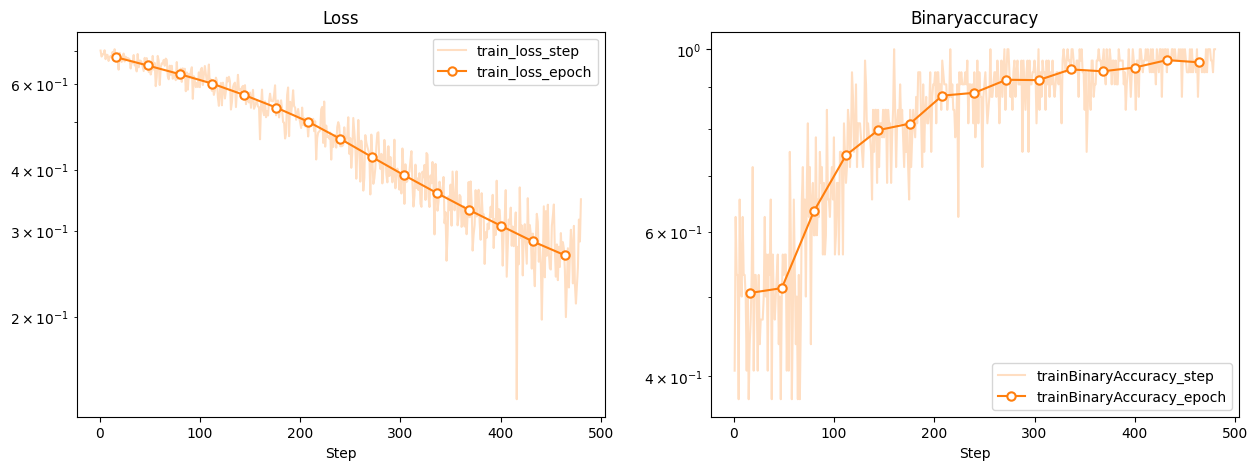

In [5]:
from deeplay.components import MultiLayerPerceptron

net = MultiLayerPerceptron(3, [64], 1, out_activation=nn.Sigmoid)
application = BinaryClassifier(net).build()

x = torch.rand(1000, 3)
target = x.sum(dim=1, keepdim=True) > 1.5

hist = application.fit((x, target), max_epochs=15)

hist.plot()

## NOTE: Defining How to Train an Application

The primary function of an application is to define how it is trained. This includes the loss function, the optimizer, and the metrics that are used to evaluate the model. Applications also define how the model is trained, including the training loop, the validation loop, and the testing loop. Applications are designed to be easy to use, so that you can get started quickly without having to worry about the details of the training process.

### Defining a Standard Training

The training step is, broadly, defined as follows:

```python
x, y = self.train_preprocess(batch)
y_hat = self(x)  # Call forward method.
loss = self.compute_loss(y_hat, y)
# logging
```

If the training can be defined in this way, then you can straightforwardly implement the `.train_preprocess()`, `.forward()`, and `.compute_loss()` methods to define the training process.

The default behavior of `.train_preprocess()` is the identity function. The `.train_preprocess()` method is intended to apply any operations that cannot be simply defined as a part of the dataset. For example, in some self-supervised models, the target is calculated from the input data. This can be done here. It can also be used to ensure the dtype of the input matches the expected dtype of the model. Most likely, you will not need to override this method.

The default behavior of `.compute_loss()` is to call `self.loss(y_hat, y)`. The `.compute_loss()` method is intended to calculate the loss of the model. This can be as simple as calling `self.loss(y_hat, y)`, or it can be more complex. It is more likely that you will need to override this method.

### Defining a More Complex Training

If the training process is more complex and you need to define a custom training loop, you can override the `.training_step()` method entirely. This method is called for each batch of data during training. It should return the loss for the batch. 

Note that if you override the `.training_step()` method, you will have to handle the logging of the loss yourself. This is done by calling `self.log("train_loss", loss, ...)` where `...` is any setting you want to pass to the logger (see `lightning.LightningModule.log()` for more information).